In [76]:
# Загрузка необходимых библиотек
import os
import numpy as np
import pandas as pd
from PIL import Image, ImageStat
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re

from mtcnn import MTCNN
import matplotlib.pyplot as plt
%matplotlib inline


import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from tqdm import tqdm

from collections import Counter
import cv2

# Путь к папкам с данными (замените на ваши пути)
train_dir = 'train'
test_dir = 'test'

### EDA

In [3]:
# Функция для сбора информации о файлах в заданной директории
def get_image_info(directory):
    image_info = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):
                filepath = os.path.join(root, file)
                image_info.append({
                    'filename': file,
                    'filepath': filepath
                })
    return pd.DataFrame(image_info)

# Сбор информации о тренировочных и тестовых данных
train_df = get_image_info(train_dir)
test_df = get_image_info(test_dir)

print(f"Количество изображений в тренировочном наборе: {len(train_df)}")
print(f"Количество изображений в тестовом наборе: {len(test_df)}")


Количество изображений в тренировочном наборе: 10099
Количество изображений в тестовом наборе: 102


In [24]:
# Регулярное выражение для извлечения класса возраста из имени файла
def extract_class(filename):
    match = re.match(r'(\d)_.*', filename)
    if match:
        return int(match.group(1))
    else:
        return None

# Применяем функцию к данным
train_df['class'] = train_df['filename'].apply(extract_class)
test_df['class'] = test_df['filename'].apply(extract_class)

# Проверка наличия файлов с некорректными именами
invalid_train_files = train_df[train_df['class'].isnull()]
invalid_test_files = test_df[test_df['class'].isnull()]

print(f"Количество файлов с некорректными именами в тренировочном наборе: {len(invalid_train_files)}")
print(f"Количество файлов с некорректными именами в тестовом наборе: {len(invalid_test_files)}")
print(invalid_train_files['filename'])


Количество файлов с некорректными именами в тренировочном наборе: 0
Количество файлов с некорректными именами в тестовом наборе: 0
Series([], Name: filename, dtype: object)


In [25]:

# **Удаляем строки с некорректными именами файлов из DataFrame**
# Из тренировочного набора
train_df = train_df[train_df['class'].notnull()].reset_index(drop=True)

# Из тестового набора
test_df = test_df[test_df['class'].notnull()].reset_index(drop=True)

#### Анализ распределения классов

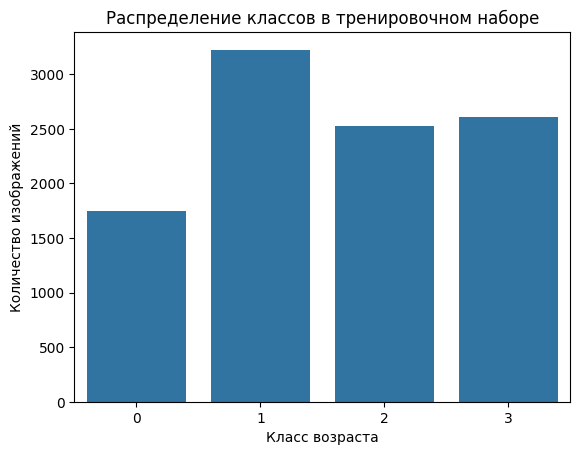

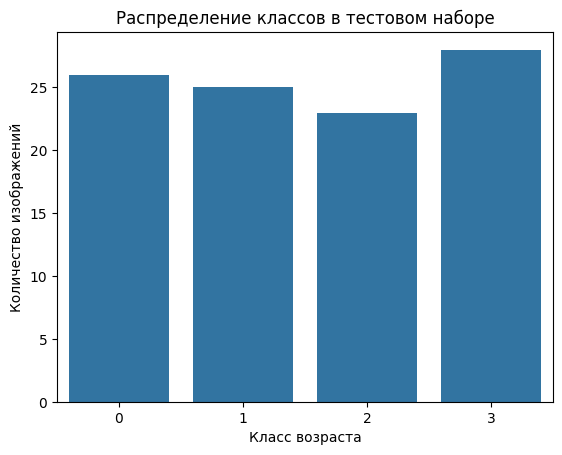

In [26]:
# Функция для визуализации распределения классов
def plot_class_distribution(df, title):
    class_counts = df['class'].value_counts().sort_index()
    sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.title(title)
    plt.xlabel('Класс возраста')
    plt.ylabel('Количество изображений')
    plt.show()

# Распределение классов в тренировочном наборе
plot_class_distribution(train_df, 'Распределение классов в тренировочном наборе')

# Распределение классов в тестовом наборе
plot_class_distribution(test_df, 'Распределение классов в тестовом наборе')


#### Проверка размеров изображений

In [14]:

# Функция для получения размеров изображений
def get_image_sizes(df):
    widths = []
    heights = []
    for filepath in df['filepath']:
        try:
            with Image.open(filepath) as img:
                width, height = img.size
                widths.append(width)
                heights.append(height)
        except Exception as e:
            print(f"Ошибка при открытии файла {filepath}: {e}")
            widths.append(None)
            heights.append(None)
    df['width'] = widths
    df['height'] = heights

# Получение размеров для тренировочного набора
get_image_sizes(train_df)
# Получение размеров для тестового набора
get_image_sizes(test_df)

# Функция для нахождения изображений с размерами не 200x200 и сохранения их в переменную
def find_invalid_size_images(df, dataset_name):
    # Фильтрация изображений с размерами, отличными от 200x200
    invalid_size_images = df[(df['width'] != 200) | (df['height'] != 200)]
    if invalid_size_images.empty:
        print(f"В наборе данных '{dataset_name}' нет изображений с размерами, отличными от 200x200.")
    else:
        print(f"Найдено {len(invalid_size_images)} изображений с размерами, отличными от 200x200, в наборе '{dataset_name}'.")
    return invalid_size_images

# Получение DataFrame с изображениями некорректного размера в тренировочном наборе
invalid_size_train_images = find_invalid_size_images(train_df, 'train')

# Получение DataFrame с изображениями некорректного размера в тестовом наборе
invalid_size_test_images = find_invalid_size_images(test_df, 'test')

Найдено 100 изображений с размерами, отличными от 200x200, в наборе 'train'.
В наборе данных 'test' нет изображений с размерами, отличными от 200x200.


#### Отрисовка граничных случаев

In [32]:
# Модифицированная функция для отображения изображений в сетке
def display_images_grid(df, title, num_images=100, columns=5):
    images_to_display = df.head(num_images)
    num_images = len(images_to_display)
    rows = (num_images + columns - 1) // columns  # Вычисляем количество строк

    plt.figure(figsize=(15, 3 * rows))
    for i, (index, row) in enumerate(images_to_display.iterrows()):
        try:
            img = Image.open(row['filepath'])
            plt.subplot(rows, columns, i+1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"{row['filename']}\n{row['width']}x{row['height']}", fontsize=8)
        except Exception as e:
            print(f"Ошибка при отображении изображения {row['filepath']}: {e}")
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Отображение изображений с неправильным размером в тренировочном наборе
#display_images_grid(invalid_size_train_images, 'Изображения с размерами, отличными от 200x200 (train)', num_images=100, columns=5)

# Отображение изображений с неправильным размером в тестовом наборе
#display_images_grid(invalid_size_test_images, 'Изображения с размерами, отличными от 200x200 (test)', num_images=100, columns=5)


#### Функция для изменения размера изображений до 200x200 пикселей

In [74]:
# Функция для изменения размера изображений до 200x200 пикселей
def resize_images_to_200x200(df):
    for index, row in df.iterrows():
        try:
            with Image.open(row['filepath']) as img:
                # Изменяем размер изображения
                img_resized = img.resize((200, 200))
                # Сохраняем изображение по тому же пути, перезаписывая его
                img_resized.save(row['filepath'])
                # Обновляем размеры в DataFrame
                df.at[index, 'width'] = 200
                df.at[index, 'height'] = 200
        except Exception as e:
            print(f"Ошибка при изменении размера изображения {row['filepath']}: {e}")

# Применяем функцию к изображениям некорректного размера в тренировочном наборе
resize_images_to_200x200(invalid_size_train_images)

# Если необходимо, также можно изменить размер изображений в тестовом наборе
# resize_images_to_200x200(invalid_size_test_images)

# Повторно получаем размеры для тренировочного набора
get_image_sizes(train_df)
# Проверяем, остались ли изображения некорректного размера в тренировочном наборе
invalid_size_train_images = find_invalid_size_images(train_df, 'train')

В наборе данных 'train' нет изображений с размерами, отличными от 200x200.


#### Нахождение изображении без фото лица

Processing images with MTCNN: 100%|██████████| 10099/10099 [17:31<00:00,  9.60it/s]


         filename  max_confidence
0   0nan_5555.jpg             0.0
1      1_8340.jpg             0.0
2       3_768.jpg             0.0
3      1_8445.jpg             0.0
4      0_1595.jpg             0.0
..            ...             ...
95     0_1024.jpg             0.0
96      2_760.jpg             0.0
97      0_448.jpg             0.0
98    3_10044.jpg             0.0
99     2_2617.jpg             0.0

[100 rows x 2 columns]


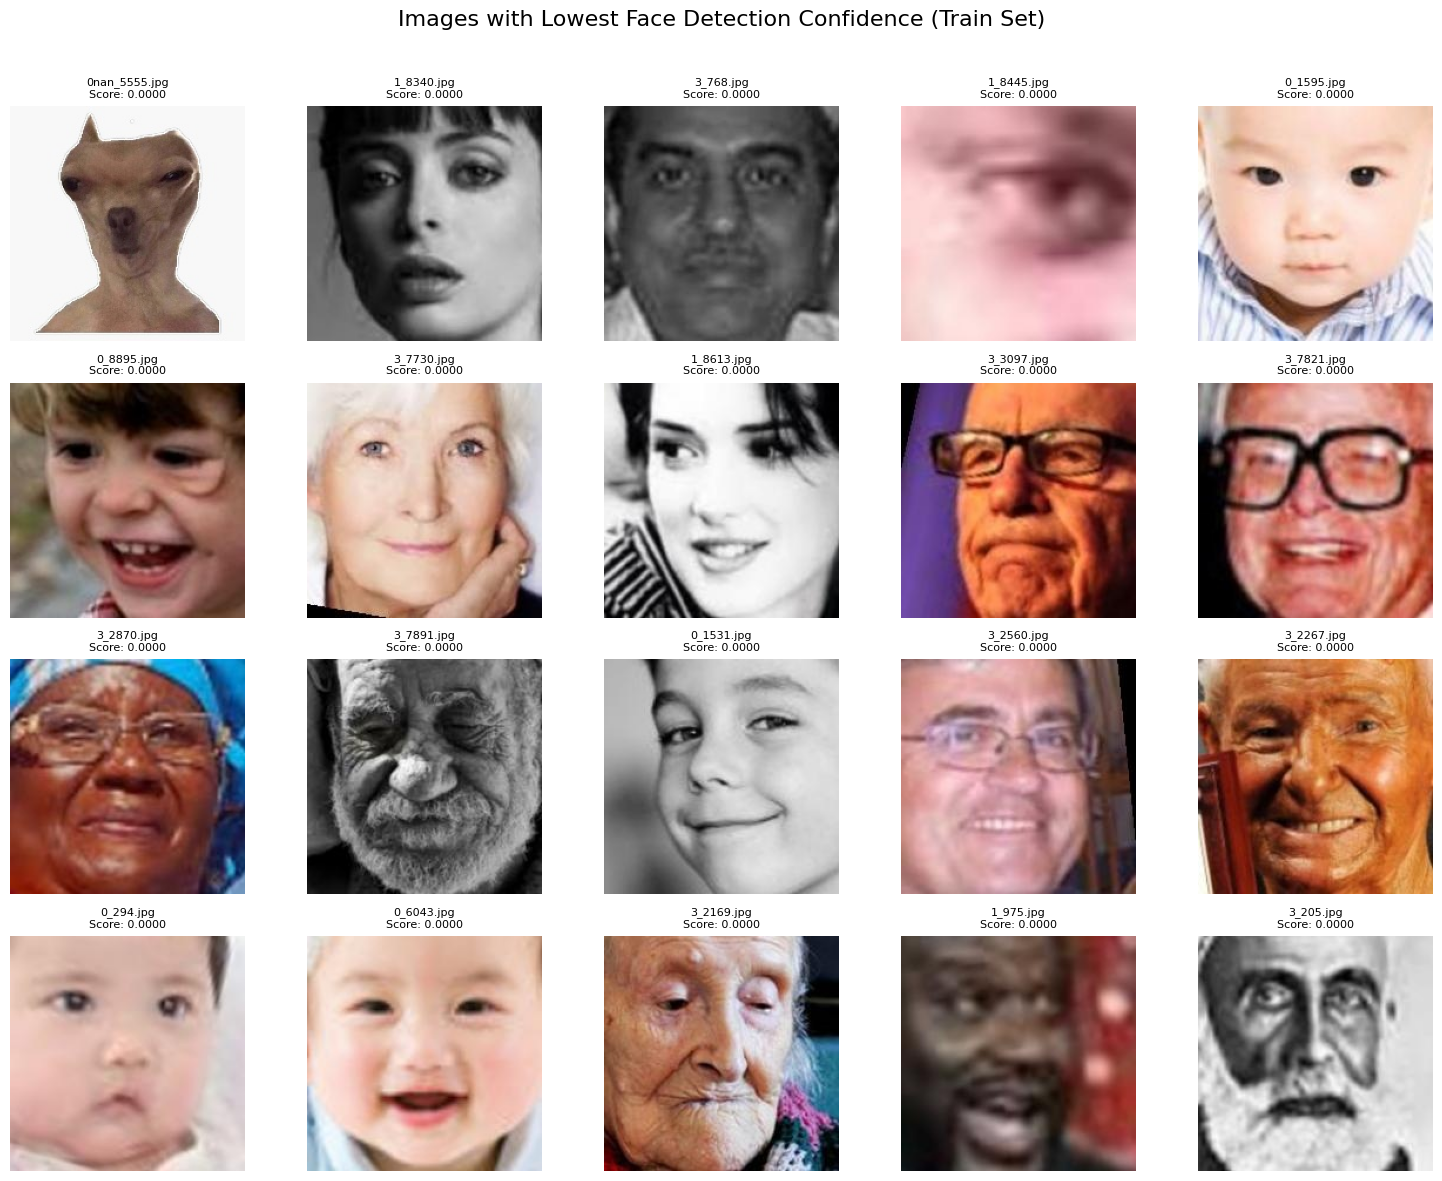

In [39]:

# Step 2: Load Your Dataset
train_dir = 'train'  
test_dir = 'test'    

def get_image_info(directory):
    image_info = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('jpg', 'jpeg', 'png')):
                filepath = os.path.join(root, file)
                image_info.append({
                    'filename': file,
                    'filepath': filepath
                })
    return pd.DataFrame(image_info)

train_df = get_image_info(train_dir)
# test_df = get_image_info(test_dir) 

# Step 3: Define Face Detection Function with Confidence Scores Using MTCNN
detector = MTCNN()

def detect_faces_mtcnn(image_path):
    try:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not read image {image_path}")
            return []
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = detector.detect_faces(img_rgb)
        confidences = []
        for result in results:
            confidence = result['confidence']
            confidences.append(confidence)
        return confidences
    except Exception as e:
        print(f"Error processing file {image_path}: {e}")
        return []

# Step 4: Apply Face Detection to Dataset and Collect Confidence Scores
def add_confidence_scores(df):
    max_confidences = []
    for filepath in tqdm(df['filepath'], desc='Processing images with MTCNN'):
        confidences = detect_faces_mtcnn(filepath)
        if confidences:
            max_confidence = max(confidences)
        else:
            max_confidence = 0  # No faces detected
        max_confidences.append(max_confidence)
    df['max_confidence'] = max_confidences

# Apply to your DataFrame
add_confidence_scores(train_df)
# add_confidence_scores(test_df)  # Uncomment if needed

# Step 5: Sort Images by Confidence Scores
train_df_sorted = train_df.sort_values(by='max_confidence', ascending=True).reset_index(drop=True)

# Step 6: Extract Top 100 Images with Lowest Confidence Scores
top_100_lowest_confidence = train_df_sorted.head(100)
print(top_100_lowest_confidence[['filename', 'max_confidence']])

In [ ]:
# Step 7: Visualize the Top 100 Images (Optional)
def display_images_grid(df, title, num_images=20, columns=5):
    images_to_display = df.head(num_images)
    num_images = len(images_to_display)
    rows = (num_images + columns - 1) // columns
    
    plt.figure(figsize=(15, 3 * rows))
    for i, (index, row) in enumerate(images_to_display.iterrows()):
        try:
            img = cv2.imread(row['filepath'])
            if img is not None:
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.subplot(rows, columns, i+1)
                plt.imshow(img_rgb)
                plt.axis('off')
                plt.title(f"{row['filename']}\nScore: {row['max_confidence']:.4f}", fontsize=8)
            else:
                print(f"Could not read image {row['filepath']}")
        except Exception as e:
            print(f"Error displaying image {row['filepath']}: {e}")
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()


In [62]:
# Display the images
# display_images_grid(train_df_sorted, 'Images with No Faces Detected (Train Set)', num_images=100, columns=5)


In [73]:
# Вручную удаляем неподходящие картинки  
files_to_remove = ['2_4626.jpg', '2_4626.jpg', '1_6259.jpg', '0nan_5555.jpg', '2_10097.jpg','3_5075.jpg', '2_10000.jpg', '0___.jpg']

train_df = train_df[~train_df['filename'].isin(files_to_remove)].reset_index(drop=True)
test_df = test_df[~test_df['filename'].isin(files_to_remove)].reset_index(drop=True)

# len(train_df)
# len(test_df)


#### Data Augmentation

Augmenting images: 100%|██████████| 10094/10094 [09:26<00:00, 17.81it/s]


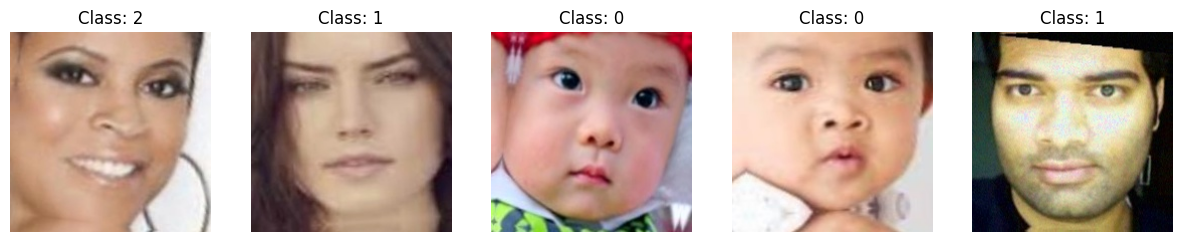

In [82]:
# Define the augmentation pipeline
def get_augmentation_pipeline():
    return A.Compose([
        A.RandomBrightnessContrast(p=0.5),
        A.Rotate(limit=15, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
        A.GaussNoise(p=0.2),
        A.MotionBlur(p=0.2),
        A.HueSaturationValue(p=0.3),
        A.RandomGamma(p=0.3),
    ])

# Directory to save augmented images
augmented_dir = 'train_augmented'
if not os.path.exists(augmented_dir):
    os.makedirs(augmented_dir)

# List to store information about augmented images
augmented_images_info = []

# Get the augmentation pipeline
augmentation_pipeline = get_augmentation_pipeline()

# Number of augmentations per image (adjust as needed)
num_augmentations = 10  # You can increase this number to generate more augmented images per original image

# Regular expression to extract class from filename
def extract_class(filename):
    match = re.match(r'(\d)_.*', filename)
    if match:
        return int(match.group(1))
    else:
        return None

# Apply augmentations to training images
for idx, row in tqdm(train_df.iterrows(), total=len(train_df), desc='Augmenting images'):
    image_path = row['filepath']
    image_filename = row['filename']
    # Extract class from filename
    class_label = extract_class(image_filename)

    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not read image {image_path}")
        continue

    # Apply augmentations
    for i in range(num_augmentations):
        augmented = augmentation_pipeline(image=image)
        augmented_image = augmented['image']

        # Create a new filename for the augmented image
        augmented_filename = f"aug_{i}_{image_filename}"
        augmented_image_path = os.path.join(augmented_dir, augmented_filename)

        # Save the augmented image
        cv2.imwrite(augmented_image_path, augmented_image)

        # Append augmented image info to the list
        augmented_images_info.append({
            'filename': augmented_filename,
            'filepath': augmented_image_path,
            'class': class_label
        })

# Create a DataFrame for augmented images
augmented_df = pd.DataFrame(augmented_images_info)

# Combine the original train_df with the augmented_df
train_df_augmented = pd.concat([train_df, augmented_df], ignore_index=True)

# Optional: Shuffle the DataFrame
train_df_augmented = train_df_augmented.sample(frac=1).reset_index(drop=True)

# Display some augmented images (optional)
def display_augmented_images(df, num_images=5):
    plt.figure(figsize=(15, 5))
    samples = df.sample(n=num_images)
    for i, (_, row) in enumerate(samples.iterrows()):
        image_path = row['filepath']
        image = cv2.imread(image_path)
        if image is not None:
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.subplot(1, num_images, i+1)
            plt.imshow(image_rgb)
            plt.axis('off')
            plt.title(f"Class: {row['class']}")
        else:
            print(f"Could not read image {image_path}")
    plt.show()

# Display some augmented images
display_augmented_images(augmented_df)

In [3]:
!cd

c:\Users\temir\Documents\GitHub\beeline\notebooks


In [4]:

# Функция для получения размеров изображений
def get_image_sizes(directory):
    image_info = []
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        try:
            with Image.open(filepath) as img:
                width, height = img.size
                image_info.append((filename, width, height))
        except Exception as e:
            print(f"Ошибка при открытии файла {filepath}: {e}")
    return image_info

# Функция для проверки размеров изображений
def check_image_dimensions(directory):
    image_info = get_image_sizes(directory)
    for filename, width, height in image_info:
        if width != 200 or height != 200:
            print(f"Изображение {filename} имеет размеры {width}x{height}, отличающиеся от 200x200")

# Прочитать папку train_augmented и проверить размеры изображений
train_augmented_dir = r'c:\Users\temir\Documents\GitHub\beeline\data\train_augmented'
check_image_dimensions(train_augmented_dir)

In [ ]:
# # Функция для получения размеров изображений
# def get_image_sizes(df):
#     widths = []
#     heights = []
#     for filepath in df['filepath']:
#         try:
#             with Image.open(filepath) as img:
#                 width, height = img.size
#                 widths.append(width)
#                 heights.append(height)
#         except Exception as e:
#             print(f"Ошибка при открытии файла {filepath}: {e}")
#             widths.append(None)
#             heights.append(None)
#     df['width'] = widths
#     df['height'] = heights

# # Получение размеров для тренировочного набора
# get_image_sizes(train_df)
# # Получение размеров для тестового набора
# get_image_sizes(test_df)

# # Функция для нахождения и вывода изображений с размерами не 200x200
# def find_and_print_invalid_size_images(df, dataset_name):
#     # Фильтрация изображений с размерами, отличными от 200x200
#     invalid_size_images = df[(df['width'] != 200) | (df['height'] != 200)]
#     print(f"\nИзображения с размерами отличными от 200x200 в наборе '{dataset_name}':")
#     if invalid_size_images.empty:
#         print("Таких изображений нет.")
#     else:
#         for index, row in invalid_size_images.iterrows():
#             print(f"{row['filename']}: {row['width']}x{row['height']}")

# # Вывод изображений с некорректными размерами в тренировочном наборе
# find_and_print_invalid_size_images(train_df, 'train')

# # Вывод изображений с некорректными размерами в тренировочном наборе
# find_and_print_invalid_size_images(train_df, 'train')

# # Вывод изображений с некорректными размерами в тестовом наборе
# find_and_print_invalid_size_images(test_df, 'test')


In [ ]:
# # Step 1: Import necessary libraries
# import os
# import cv2
# import pandas as pd
# from mtcnn.mtcnn import MTCNN
# from tqdm import tqdm
# import matplotlib.pyplot as plt
# %matplotlib inline


# # Define the directory for your train images
# train_dir = 'train'  # Replace with your actual path

# # Function to get image file information
# def get_image_info(directory):
#     image_info = []
#     for root, _, files in os.walk(directory):
#         for file in files:
#             if file.lower().endswith(('.jpg', '.jpeg', '.png')):
#                 filepath = os.path.join(root, file)
#                 image_info.append({
#                     'filename': file,
#                     'filepath': filepath
#                 })
#     return pd.DataFrame(image_info)

# # Load the train dataset
# train_df = get_image_info(train_dir)
# print(f"Total images in train dataset: {len(train_df)}")


# # Initialize the MTCNN face detector
# detector = MTCNN()


# # List to hold information about images with no faces detected
# no_face_images_info = []

# # Function to detect faces and collect images with no faces
# def detect_faces_and_collect_no_face_images(df):
#     # For progress bar
#     for idx, row in tqdm(df.iterrows(), total=len(df), desc='Processing images'):
#         filepath = row['filepath']
#         try:
#             # Read the image
#             img = cv2.imread(filepath)
#             if img is None:
#                 print(f"Could not read image: {filepath}")
#                 continue
            
#             # Convert image to RGB
#             img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#             # Detect faces
#             results = detector.detect_faces(img_rgb)

#             # If no faces detected, collect the image info
#             if not results:
#                 no_face_images_info.append({
#                     'filename': row['filename'],
#                     'filepath': filepath
#                 })
#         except Exception as e:
#             print(f"Error processing file {filepath}: {e}")

# # Apply the function to the train dataset
# detect_faces_and_collect_no_face_images(train_df)


# # Create DataFrame from the collected information
# no_face_train_images = pd.DataFrame(no_face_images_info)

# # Print the number of images with no faces detected
# print(f"Number of images with no faces detected: {len(no_face_train_images)}")


# def display_images_grid(df, title, num_images=100, columns=5):
#     images_to_display = df.head(num_images)
#     num_images = len(images_to_display)
#     rows = (num_images + columns - 1) // columns

#     plt.figure(figsize=(15, 3 * rows))
#     for i, (index, row) in enumerate(images_to_display.iterrows()):
#         try:
#             img = cv2.imread(row['filepath'])
#             if img is not None:
#                 img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#                 plt.subplot(rows, columns, i+1)
#                 plt.imshow(img_rgb)
#                 plt.axis('off')
#                 plt.title(f"{row['filename']}", fontsize=8)
#             else:
#                 print(f"Could not read image {row['filepath']}")
#         except Exception as e:
#             print(f"Error displaying image {row['filepath']}: {e}")
#     plt.suptitle(title, fontsize=16)
#     plt.tight_layout()
#     plt.subplots_adjust(top=0.95)
#     plt.show()

# # Display the images
# display_images_grid(no_face_train_images, 'Images with No Faces Detected (Train Set)', num_images=100, columns=5)
